In [2]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c, h, k_B, M_sun, L_sun
from matplotlib.patches import Rectangle
from tqdm import tqdm
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from lmfit import Model, Parameters
from collections import Counter
from itertools import zip_longest, combinations, chain
from scipy.stats import cumfreq
from functools import partial
from labellines import labelLines
from scipy.stats import binned_statistic
utils.rcparams()

In [3]:
herschel = utils.full_loader('Herschel')
vla = utils.full_loader('VLA_COSMOS2020_05')

vla['lp_zPDF_low'] = vla['lp_zPDF']-vla['lp_zPDF_l68']
vla['lp_zPDF_high'] = vla['lp_zPDF_u68']-vla['lp_zPDF']
vla['lp_zPDF_err'] = (vla['lp_zPDF_low']+vla['lp_zPDF_high'])/2

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [50]:
cosmos2020 = utils.full_loader('COSMOS2020')

/Users/bradleyward/Desktop/Radio-IDs/utils/loader.py:19: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  data = read_csv(file_path)


### Classes and Functions

In [4]:
class Object:

    def __init__(self, name, ra_deg, dec_deg):
        self.id = name
        self.ra = ra_deg
        self.dec = dec_deg


class Source(Object):

    def __init__(self, name, ra, dec, wavelengths_obs_um, fluxes, flux_errors):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.wavelengths_obs_um = wavelengths_obs_um
        self.fluxes = fluxes
        self.flux_errors = flux_errors


class Counterpart(Object):

    def __init__(self, name, ra, dec, fluxes, redshift, redshift_err, **kwargs):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.fluxes = fluxes
        self.redshift = redshift
        self.redshift_err = redshift_err
        self.stellar_mass = kwargs.get('stellar_mass')
        self.u_mag, self.g_mag, self.r_mag, self.i_mag, self.z_mag, = kwargs.get('u_mag'), kwargs.get('g_mag'), kwargs.get('r_mag'), kwargs.get('i_mag'), kwargs.get('z_mag')
        self.fuv_mag, self.nuv_mag = kwargs.get('fuv_mag'), kwargs.get('nuv_mag')
        self.y_mag, self.j_mag, self.h_mag, self.k_mag = kwargs.get('y_mag'), kwargs.get('j_mag'), kwargs.get('h_mag'), kwargs.get('k_mag')

    @property
    def luminosity_distance(self):
        return cosmo.luminosity_distance(z = self.redshift)

    def number_density(self, counterparts, area):
        return np.sum([counterpart.fluxes > self.fluxes for counterpart in counterparts])/area

    def separation(self, other):
        return np.sqrt(((self.ra - other.ra)**2)+((self.dec - other.dec)**2))*3600

    def s_value(self, source, counterparts, area):
        r = self.separation(source)
        n = self.number_density(counterparts, area)
        s = (r**2)*n
        return s

In [5]:
# Create a set of N random sources
def random_sources(n, ra_min, ra_max, dec_min, dec_max):
    sources_rand = []
    for it in range(n):
        ra_random, dec_random = np.random.uniform(ra_min, ra_max), np.random.uniform(dec_min, dec_max)
        random_source = Source(it, ra_random, dec_random, np.array([0]), np.array([0]), np.array([0]))
        sources_rand.append(random_source)
    return sources_rand

In [6]:
def separation_to_distance(r, z):
    r = r*u.arcsec
    d_A = cosmo.angular_diameter_distance(z)
    distance_kpc = (r*d_A).to(u.kpc, u.dimensionless_angles())
    return distance_kpc.value

def distance_to_separation(d, z):
    d = d*u.kpc
    d_A = cosmo.angular_diameter_distance(z)
    r = (d/d_A).to(u.arcsec, u.dimensionless_angles())
    return r.value

In [7]:
def apply_flux_limit(groups, flux_lim, flux_lim_idx=0):
    groups_flux = {}
    groups_flux['blanks'] = [source for source in groups['blanks'] if source.fluxes[flux_lim_idx] > flux_lim]
    groups_flux['singles'] = [pair for pair in groups['singles'] if pair.source.fluxes[flux_lim_idx] > flux_lim]
    groups_flux['multiples'] = [group for group in groups['multiples'] if group.source.fluxes[flux_lim_idx] > flux_lim]
    groups_flux['primaries'] = [pair for pair in groups['primaries'] if pair.source.fluxes[flux_lim_idx] > flux_lim]
    groups_flux['secondaries'] = [pair for pair in groups['secondaries'] if pair.source.fluxes[flux_lim_idx] > flux_lim]
    groups_flux['tertiaries'] = [pair for pair in groups['tertiaries'] if pair.source.fluxes[flux_lim_idx] > flux_lim]
    return groups_flux

In [8]:
def bb(nu, t):
    return (nu**3)*(1/(np.exp((h.value*nu)/(k_B.value*t)) - 1))


def mbb(nu_rest, log_norm, t, beta):
    norm = 10**log_norm
    return norm*(nu_rest**beta)*bb(nu_rest, t)


def create_sources_and_counterparts(source_params, counterpart_params):

    source_catalogue = []
    for obj in tqdm(range(len(source_params['data'])), desc='Creating Sources'):
        name = source_params['data'][source_params['name']][obj]
        ra = source_params['data'][source_params['ra']][obj]
        dec = source_params['data'][source_params['dec']][obj]
        wavelengths_obs_um = source_params['wavelengths_obs_um']
        fluxes = np.array(source_params['data'][source_params['fluxes']].iloc[obj])
        flux_errors = np.array(source_params['data'][source_params['flux_errors']].iloc[obj])
        source = Source(name, ra, dec, wavelengths_obs_um, fluxes, flux_errors)
        source_catalogue.append(source)

    counterpart_catalogue = []
    for obj in tqdm(range(len(counterpart_params['data'])), desc='Creating Counterparts'):
        name = counterpart_params['data'][counterpart_params['name']][obj]
        ra = counterpart_params['data'][counterpart_params['ra']][obj]
        dec = counterpart_params['data'][counterpart_params['dec']][obj]
        fluxes = np.array(counterpart_params['data'][counterpart_params['fluxes']].iloc[obj])
        redshift = counterpart_params['data'][counterpart_params['redshift']][obj]
        redshift_err = counterpart_params['data'][counterpart_params['redshift_err']][obj]

        stellar_mass = counterpart_params['data']['lp_mass_med'][obj]

        u_mag = counterpart_params['data']['lp_MU'][obj]
        g_mag = counterpart_params['data']['lp_MG'][obj]
        r_mag = counterpart_params['data']['lp_MR'][obj]
        i_mag = counterpart_params['data']['lp_MI'][obj]
        z_mag = counterpart_params['data']['lp_MZ'][obj]
        fuv_mag = counterpart_params['data']['lp_MFUV'][obj]
        nuv_mag = counterpart_params['data']['lp_MNUV'][obj]
        y_mag = counterpart_params['data']['lp_MY'][obj]
        j_mag = counterpart_params['data']['lp_MJ'][obj]
        h_mag = counterpart_params['data']['lp_MH'][obj]
        k_mag = counterpart_params['data']['lp_MK'][obj]

        counterpart = Counterpart(name, ra, dec, fluxes, redshift, redshift_err,
                                  stellar_mass=stellar_mass,
                                  u_mag=u_mag,
                                  g_mag=g_mag,
                                  r_mag=r_mag,
                                  i_mag=i_mag,
                                  z_mag=z_mag,
                                  fuv_mag=fuv_mag,
                                  nuv_mag=nuv_mag,
                                  y_mag=y_mag,
                                  j_mag=j_mag,
                                  h_mag=h_mag,
                                  k_mag=k_mag)
        counterpart_catalogue.append(counterpart)

    return source_catalogue, counterpart_catalogue

In [9]:
class Pair:

    def __init__(self, source, counterpart, r, s, p, fit_sed=True):
        self.source = source
        self.counterpart = counterpart
        self.r = r
        self.s = s
        self.p = p

        self.t_cmb = 2.725*(1+self.counterpart.redshift)
        self.source.wavelengths_obs_m = self.source.wavelengths_obs_um*1e-6
        self.source.wavelengths_rest_m = self.source.wavelengths_obs_m/(1+self.counterpart.redshift)
        self.source.nu_rest = c.value/self.source.wavelengths_rest_m

        if fit_sed:

            if np.isnan(self.counterpart.redshift):
                self.log_norm = np.nan
                self.t = np.nan
                self.beta = np.nan
            else:
                mbb_model = Model(mbb)
                params = Parameters()
                params.add_many(('log_norm', -60, True, -65, -55),
                                ('t', 20, True, self.t_cmb, 50),
                                ('beta', 2, True, 1, 4))
                mbb_fit = mbb_model.fit(self.source.fluxes, params, nu_rest=self.source.nu_rest, weights=1/self.source.flux_errors)

                self.log_norm = mbb_fit.params['log_norm'].value
                self.t = mbb_fit.params['t'].value
                self.beta = mbb_fit.params['beta'].value

    def sed(self, nu_rest):
        return mbb(nu_rest, self.log_norm, self.t, self.beta)*u.Jy

    def fir_luminosity(self, lam_um_rest_low=8, lam_um_rest_high=1000):
        lam_low_um_rest, lam_high_um_rest = lam_um_rest_low*u.micron, lam_um_rest_high*u.micron
        wave_range_rest_um = np.linspace(1, 5000, 100000) * u.micron
        wave_range_rest_m = wave_range_rest_um.to(u.m)
        freq_range_rest = c / wave_range_rest_m
        idx = np.where((wave_range_rest_um >= lam_low_um_rest) & (wave_range_rest_um <= lam_high_um_rest))

        diff_freq = np.diff(freq_range_rest)
        diff_freq = np.append(diff_freq, diff_freq[-1])

        sed_obs_integral = self.sed(freq_range_rest[idx].value)
        sed_rest_integral = sed_obs_integral/(1+self.counterpart.redshift)
        integral = np.sum(-sed_rest_integral*diff_freq[idx])

        d_L = cosmo.luminosity_distance(z=self.counterpart.redshift).to(u.m)
        l_watt = (4 * np.pi * (d_L ** 2) * integral).to(u.Watt)
        l_sun = l_watt.to(u.L_sun)
        return l_sun

    def sfr(self):
        # From Murphy+2011
        l_sun = self.fir_luminosity()
        l_cgs = l_sun.to(u.erg/u.s)
        constant = 3.88e-44*(u.M_sun/u.yr)/(u.erg/u.s)
        sfr = constant*l_cgs
        return sfr


class Group:

    def __init__(self, pairs):
        self.pairs = pairs
        self.counterparts = [pair.counterpart for pair in self.pairs]
        self.source = [pair.source for pair in self.pairs][0]

    @property
    def average_counterpart_source_separation(self):
        av_counterpart_ra = np.mean([pair.counterpart.ra for pair in self.pairs])
        av_counterpart_dec = np.mean([pair.counterpart.dec for pair in self.pairs])
        source_ra, source_dec = self.pairs[0].source.ra, self.pairs[0].source.dec
        separation = np.sqrt(((source_ra - av_counterpart_ra)**2)+((source_dec - av_counterpart_dec)**2))*3600
        return separation

    @property
    def counterpart_flux_sorted(self, n_max=3):
        fluxes = sorted([obj.fluxes.item() for obj in self.counterparts], reverse=True)
        n = len(fluxes)
        return np.pad(fluxes, (0,n_max-n), 'constant', constant_values=np.nan)

    def counterpart_source_separations(self):
        separations_arcsec = [pair.r for pair in self.pairs]
        return separations_arcsec

    def counterpart_counterpart_separations(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        separations_arcsec = [self.pairs[it[0]].counterpart.separation(self.pairs[it[1]].counterpart) for it in index_list]
        return separations_arcsec

    def counterpart_counterpart_z_difference(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        z_diff = [abs(self.pairs[it[0]].counterpart.redshift - self.pairs[it[1]].counterpart.redshift) for it in index_list]
        z_diff_err = [np.sqrt((self.pairs[it[0]].counterpart.redshift_err**2) + (self.pairs[it[1]].counterpart.redshift_err**2)) for it in index_list]
        return z_diff, z_diff_err

    def counterpart_flux_contribution(self):
        fluxes = self.counterpart_flux_sorted
        total_flux = np.nansum(fluxes)
        contribution = fluxes/total_flux
        return contribution


class Survey:

    def __init__(self, sources, counterparts):

        # Input sources and counterparts
        self.sources_all = sources
        self.counterparts_all = counterparts
        print('Input Number of Sources = {}'.format(len(self.sources_all)))
        print('Input Number of Counterparts = {}'.format(len(self.counterparts_all)))

        # Define the overlapping survey area
        sources_ra = [self.sources_all[obj].ra for obj in range(len(self.sources_all))]
        sources_dec = [self.sources_all[obj].dec for obj in range(len(self.sources_all))]
        counterparts_ra = [self.counterparts_all[obj].ra for obj in range(len(self.counterparts_all))]
        counterparts_dec = [self.counterparts_all[obj].dec for obj in range(len(self.counterparts_all))]
        self.ra_min, self.ra_max = max(min(sources_ra),min(counterparts_ra)), min(max(sources_ra),max(counterparts_ra))
        self.dec_min, self.dec_max = max(min(sources_dec),min(counterparts_dec)), min(max(sources_dec),max(counterparts_dec))
        self.area_deg = (abs(self.ra_max - self.ra_min)) * (abs(self.dec_max - self.dec_min))
        self.area_arcsec = (np.sqrt(self.area_deg)*3600)**2

        # Reduce sources and counterparts to overlapping region
        self.sources = [obj for obj in self.sources_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        self.counterparts = [obj for obj in self.counterparts_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        print('Overlapping Number of Sources = {} ({:.2f}%)'.format(len(self.sources), (len(self.sources)/len(self.sources_all))*100))
        print('Overlapping Number of Counterparts = {} ({:.2f}%)'.format(len(self.counterparts), (len(self.counterparts)/len(self.counterparts_all))*100))

    # Get random sources
    def get_random_sources(self, n):
        sources_rand = random_sources(n, self.ra_min, self.ra_max, self.dec_min, self.dec_max)
        return sources_rand

    def get_s_values(self, r_max_arcsec, n=100000, random=False, disable=False):
        if random:
            sources = self.get_random_sources(n)
        else:
            sources = self.sources

        min_s_values = []
        for source in tqdm(sources, desc = 'Calculating S Values', disable=disable):
            counterpart_s_values = []
            r_max_deg = r_max_arcsec/3600
            ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
            possible_counterparts = [counterpart for counterpart in self.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
            for counterpart in possible_counterparts:
                r = counterpart.separation(source)
                if r <= r_max_arcsec:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    counterpart_s_values.append(s)
            min_s = min(counterpart_s_values, default=np.nan)
            min_s_values.append(min_s)
        min_s_values_finite = np.array([s for s in min_s_values if np.isfinite(s)])
        min_s_values_finite_sorted = sorted(min_s_values_finite)
        return min_s_values_finite_sorted

    def get_matches(self, r_max_arcsec, p_max, n=100000, disable=False):
        d_s_random = self.get_s_values(r_max_arcsec=r_max_arcsec, n=n, random=True, disable=disable)
        survey_pairs = []
        for source in tqdm(self.sources, desc='Calculating P Values', disable=disable):
            source_pairs = []
            r_max_deg = r_max_arcsec/3600
            ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
            possible_counterparts = [counterpart for counterpart in self.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
            for counterpart in possible_counterparts:
                r = counterpart.separation(source)
                if r <= r_max_arcsec:
                    s_i = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    p = len([s for s in d_s_random if s < s_i])/n
                    if p < 1/n:
                        p = 1/n
                    if p <= p_max:
                        pair = Pair(source, counterpart, r, s_i, p)
                        source_pairs.append(pair)
            source_pairs_sorted = sorted(source_pairs, key = lambda pair: pair.p)
            survey_pairs.append(source_pairs_sorted)
        return d_s_random, survey_pairs

    def get_groups(self, r_max_arcsec, p_max, n=100000, disable=False):
        d_s_random, survey_pairs = self.get_matches(r_max_arcsec=r_max_arcsec, p_max=p_max, n=n, disable=disable)
        survey_array = np.array(list(zip_longest(*survey_pairs, fillvalue=np.nan))).T

        try:
            blanks_idx = [idx for idx,pairs in enumerate(survey_array) if pd.isna([pairs[0]])]
            blanks_sources = [self.sources[i] for i in blanks_idx]
        except:
            blanks_sources = []
            print('No Blank Sources')

        try:
            singles = survey_array[pd.isna(survey_array[:, 1])][:,0]
            singles_pairs = [pair for pair in singles if ~pd.isna([pair])]
        except:
            singles_pairs = []
            print('No Single Sources')

        try:
            multiples = survey_array[~pd.isna(survey_array[:,1])]
            multiples_list = [multiples[it][~pd.isna(multiples[it])].tolist() for it in range(len(multiples))]
            multiples_group = [Group(pairs=pairs) for pairs in multiples_list]
        except:
            multiples_group = []
            print('No Multiple Sources')

        try:
            primaries_list = [pairs[0] for pairs in survey_array if ~pd.isna([pairs[0]])]
        except:
            primaries_list = []
            print('No Primary Objects')

        try:
            secondaries_list = [pairs[1] for pairs in survey_array if ~pd.isna([pairs[1]])]
        except:
            secondaries_list = []
            print('No Secondary Objects')

        try:
            tertiaries_list = [pairs[2] for pairs in survey_array if ~pd.isna([pairs[2]])]
        except:
            tertiaries_list = []
            print('No Tertiary Objects')

        groups = {
                'blanks': blanks_sources,
                'singles': singles_pairs,
                'multiples': multiples_group,
                'primaries': primaries_list,
                'secondaries': secondaries_list,
                'tertiaries': tertiaries_list}

        return d_s_random, groups


### Create Survey

In [10]:
source_params = {'data': herschel,
                 'name': 'id_her',
                 'ra': 'RA_her',
                 'dec': 'Dec_her',
                 'wavelengths_obs_um': np.array([250,350,500]),
                 'fluxes': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500'],
                 'flux_errors': ['FErr_BLIND_MF_SPIRE_250', 'FErr_BLIND_MF_SPIRE_350', 'FErr_BLIND_MF_SPIRE_500']}

counterpart_params = {'data': vla,
                      'name': 'id_cos',
                      'ra': 'RA_cos',
                      'dec': 'Dec_cos',
                      'fluxes': ['total_int_flux'],
                      'redshift': 'lp_zPDF',
                      'redshift_err': 'lp_zPDF_err'}

In [11]:
herschel_objects, vla_objects = create_sources_and_counterparts(source_params, counterpart_params)
cosmos = Survey(herschel_objects, vla_objects)
print('Region being used: RA - {:.3f} to {:.3f}, DEC - {:.3f} to {:.3f}'.format(cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max))

Creating Counterparts: 100%|██████████| 10830/10830 [00:01<00:00, 7977.68it/s]

Input Number of Sources = 11185
Input Number of Counterparts = 10830
Overlapping Number of Sources = 7230 (64.64%)
Overlapping Number of Counterparts = 10826 (99.96%)
Region being used: RA - 149.289 to 150.952, DEC - 1.452 to 3.038


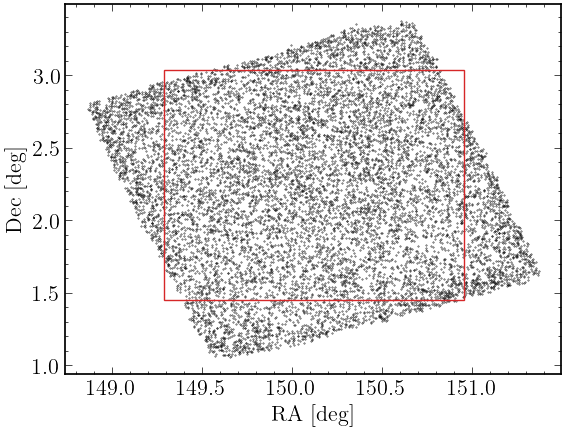

In [12]:
herschel_ras = [herschel_objects[it].ra for it in range(len(herschel_objects))]
herschel_decs = [herschel_objects[it].dec for it in range(len(herschel_objects))]

fig, ax = plt.subplots()
ax.scatter(herschel_ras, herschel_decs, s=0.1)
ax.add_patch(Rectangle((cosmos.ra_min, cosmos.dec_min), cosmos.ra_max-cosmos.ra_min, cosmos.dec_max-cosmos.dec_min, edgecolor='tab:red', facecolor='none'))
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'Dec [deg]')
plt.savefig(utils.ROOT+'/figures/sky_map.pdf', dpi=1000)
plt.show()

### Optimal Search Radius

In [92]:
N = len(cosmos.sources)
r_max_arcsec = 30

rand_sources = random_sources(N, cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max)

rand_r = []
rand_f = []
herschel_r = []
herschel_f = []

for source in tqdm(rand_sources, desc='Random Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        f = counterpart.fluxes.item()
        if r <= r_max_arcsec:
            rand_r.append(r)
            rand_f.append(f)

for source in tqdm(cosmos.sources, desc='Herschel Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        f = counterpart.fluxes.item()
        if r <= r_max_arcsec:
            herschel_r.append(r)
            herschel_f.append(f)

rand_r_hist, bin_edges = np.histogram(rand_r, bins=30, range=(0,30))
herschel_r_hist, _ = np.histogram(herschel_r, bins=30, range=(0,30))
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

rand_r_cum = cumfreq(rand_r, 30, defaultreallimits=(0,30))
herschel_r_cum = cumfreq(herschel_r, 30, defaultreallimits=(0,30))

rand_r_freq = np.array(rand_r_cum.cumcount)
herschel_r_freq = np.array(herschel_r_cum.cumcount)

Herschel Sources: 100%|██████████| 7230/7230 [00:04<00:00, 1537.02it/s]


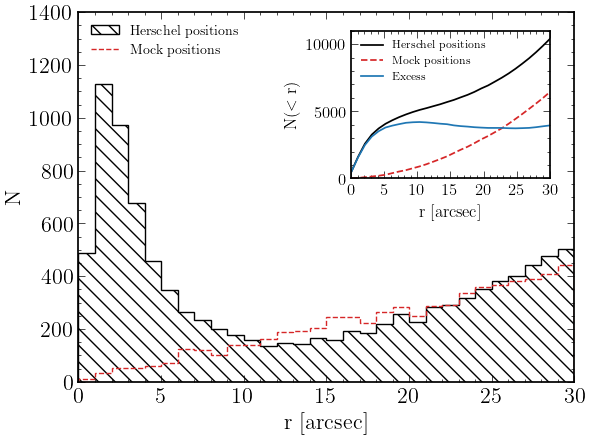

In [14]:
r_range = np.linspace(0,30,30)

fig, ax = plt.subplots()
ax.stairs(herschel_r_hist, bin_edges, hatch=r'\\', label=r'Herschel positions')
ax.stairs(rand_r_hist, bin_edges, linestyle='--', label=r'Mock positions')

axin = ax.inset_axes([0.55,0.55,0.4,0.4])
axin.plot(r_range, herschel_r_freq, label=r'Herschel positions')
axin.plot(r_range, rand_r_freq, linestyle='--', label=r'Mock positions')
axin.plot(r_range, herschel_r_freq-rand_r_freq, label=r'Excess')
axin.set_xlabel(r'r [arcsec]', fontsize=12)
axin.set_ylabel(r'N($<$ r)', fontsize=12)
axin.tick_params(axis='both', labelsize=12)
axin.set_xticks([0,5,10,15,20,25,30])
axin.set_xlim(0,30)
axin.set_ylim(0,11000)
axin.legend(fontsize=8)

ax.set_xlim(0,30)
ax.set_ylim(0,1400)
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.legend(loc='upper left', fontsize=10)
plt.savefig(utils.ROOT+'/figures/optimal_radius.pdf', dpi=1000)
plt.show()

### Estimate of Maximum P

Expected maximum P based on Poisson statistics:
Let X be the number of VLA sources observed within a single search radius

$$\lambda = N_{\textrm{VLA}}A_{\textrm{Circle}}/A_{\textrm{Survey}}$$

\begin{align}
    P_{\textrm{max}} &\sim \frac{P(\textrm{Not-blank})}{P(\textrm{Blank})} \\
    &= \frac{P(X > 0)}{P(X = 0)} \\
    &= \frac{1-P(X = 0)}{P(X = 0)} \\
    &= \frac{1-e^{-\lambda}}{e^{-\lambda}}
\end{align}

In [15]:
# Expected maximum P value (ignoring overlapping regions and assuming Poisson statistics)

r_max = 10
N_vla = len(cosmos.counterparts)
a_circle = np.pi*(r_max**2)
a_survey = cosmos.area_arcsec
lam = (N_vla*a_circle)/a_survey
prob_max = (1-np.exp(-lam))/(np.exp(-lam))
print('The number density of VLA objects = {:.2f} per square degree'.format(N_vla/cosmos.area_deg))
print('The maximum probability is expected to be approximately = {:.2f}'.format(prob_max))

The number density of VLA objects = 4103.01 per square degree
The maximum probability is expected to be approximately = 0.10


### D(S) Distributions and Create Sample

In [16]:
r_max = 10
p_max = 0.05

herschel_ds = cosmos.get_s_values(r_max_arcsec=r_max)
random_ds, herschel_vla = cosmos.get_groups(r_max_arcsec=r_max, p_max=p_max, n=100000)

Calculating P Values: 100%|██████████| 7230/7230 [00:44<00:00, 161.53it/s]


/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_12443/1186990355.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.hist(np.log10(random_ds), bins=250, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)


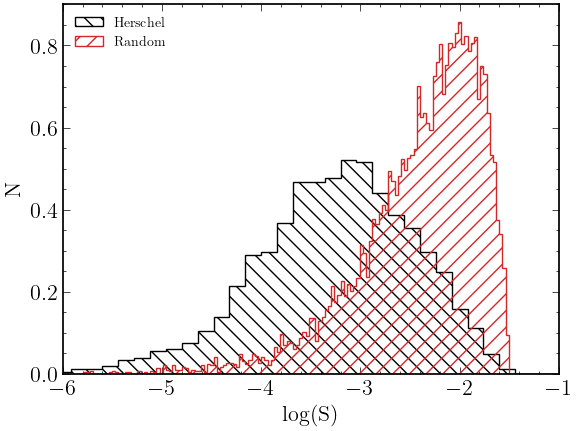

In [17]:
logs_range = (-8,0)

fig, ax = plt.subplots()
ax.hist(np.log10(herschel_ds), bins=50, range=logs_range, histtype='step', hatch=r'\\', label=r'Herschel', density=True)
ax.hist(np.log10(random_ds), bins=250, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)
ax.set_xlabel(r'log(S)')
ax.set_ylabel(r'N')
ax.set_xlim(-6,-1)
ax.legend(fontsize=10, loc='upper left')
plt.savefig(utils.ROOT+'/figures/ds_distributions.pdf', dpi=1000)
plt.show()

In [18]:
flux_limit = 0.03
herschel_vla_flux = apply_flux_limit(herschel_vla, flux_limit)

### Important Statistics

In [19]:
n_sources = len(cosmos.sources)
n_counterparts = len(cosmos.counterparts)
n_sources_flux = len([source for source in cosmos.sources if source.fluxes[0] > flux_limit])

n_ids = len(herschel_vla['primaries'])
n_ids_flux = len(herschel_vla_flux['primaries'])

n_false = np.sum([pair.p for pair in herschel_vla['primaries']])
n_false_flux = np.sum([pair.p for pair in herschel_vla_flux['primaries']])

print('The number of Herschel sources = {}'.format(n_sources))
print('The number of VLA sources = {}'.format(n_counterparts))
print('The number of sources with IDs = {} ({:.2f}%)'.format(n_ids, (n_ids/n_sources)*100))
print('The number of false IDs to sources = {:.2f} ({:.2f}%)'.format(n_false, (n_false/n_sources)*100))

print('The number of Herschel sources > {} mJy = {}'.format(flux_limit*1000, n_sources_flux))
print('The number of sources > {} mJy with IDs = {} ({:.2f}%)'.format(flux_limit*1000, n_ids_flux, (n_ids_flux/n_sources_flux)*100))
print('The number of false IDs to sources > {} mJy = {:.2f} ({:.2f}%)'.format(flux_limit*1000, n_false_flux, (n_false_flux/n_sources_flux)*100))

The number of Herschel sources = 7230
The number of VLA sources = 10826
The number of sources with IDs = 3787 (52.38%)
The number of false IDs to sources = 47.18 (0.65%)
The number of Herschel sources > 30.0 mJy = 1324
The number of sources > 30.0 mJy with IDs = 1053 (79.53%)
The number of false IDs to sources > 30.0 mJy = 6.53 (0.49%)


In [20]:
counter_flux = Counter([len([pairs]) for pairs in herschel_vla_flux['singles']])+Counter([len(group.pairs) for group in herschel_vla_flux['multiples']])
print('The number of IDs per source > {} mJy: {}'.format(flux_limit*1000, counter_flux))

The number of IDs per source > 30.0 mJy: Counter({1: 879, 2: 160, 3: 14})


In [21]:
print('The average number of potential counterparts to each source = {:.2f}'.format(len(cosmos.counterparts)/len(cosmos.sources)))

The average number of potential counterparts to each source = 1.50


### ID Fraction

In [22]:
flux_range = np.logspace(-2.5, 0, 30)

all_fluxes, bin_edges = np.histogram([obj.fluxes[0] for obj in cosmos.sources], bins=flux_range)
primaries_fluxes = [pair.source.fluxes[0] for pair in herschel_vla['primaries']]
singles_fluxes = [pair.source.fluxes[0] for pair in herschel_vla['singles']]
multiples_fluxes = [group.source.fluxes[0] for group in herschel_vla['multiples']]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

primaries_fluxes_id = np.histogram(primaries_fluxes, bins=flux_range)[0]/all_fluxes
primaries_fluxes_id_err = np.sqrt(np.histogram(primaries_fluxes, bins=flux_range)[0])/all_fluxes
singles_fluxes_id = np.histogram(singles_fluxes, bins=flux_range)[0]/all_fluxes
multiples_fluxes_id = np.histogram(multiples_fluxes, bins=flux_range)[0]/all_fluxes

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_12443/2652068047.py:9: RuntimeWarning: invalid value encountered in divide
  primaries_fluxes_id = np.histogram(primaries_fluxes, bins=flux_range)[0]/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_12443/2652068047.py:10: RuntimeWarning: invalid value encountered in divide
  primaries_fluxes_id_err = np.sqrt(np.histogram(primaries_fluxes, bins=flux_range)[0])/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_12443/2652068047.py:11: RuntimeWarning: invalid value encountered in divide
  singles_fluxes_id = np.histogram(singles_fluxes, bins=flux_range)[0]/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_12443/2652068047.py:12: RuntimeWarning: invalid value encountered in divide
  multiples_fluxes_id = np.histogram(multiples_fluxes, bins=flux_range)[0]/all_fluxes


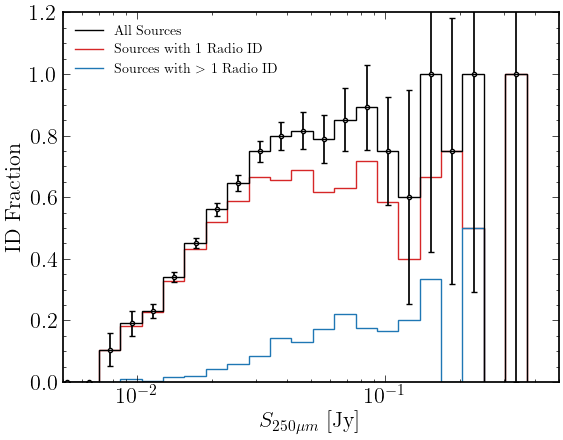

In [23]:
fig, ax = plt.subplots()
ax.stairs(primaries_fluxes_id, flux_range, label=r'All Sources', zorder=10)
ax.errorbar(bin_centers, primaries_fluxes_id, yerr=primaries_fluxes_id_err, fmt='.', c='k')
ax.stairs(singles_fluxes_id, flux_range, label=r'Sources with 1 Radio ID')
ax.stairs(multiples_fluxes_id, flux_range, label=r'Sources with $>$ 1 Radio ID')
ax.set_xlabel(r'$S_{250\mu m}$ [Jy]')
ax.set_ylabel(r'ID Fraction')
ax.set_xlim(5e-3,5e-1)
ax.set_ylim(0,1.2)
ax.semilogx()
ax.legend(loc='upper left', fontsize=10)
plt.savefig(utils.ROOT+'/figures/id_fraction_radio.pdf', dpi=1000)
plt.show()

### Source-Counterpart Offsets

In [24]:
primaries_sc_offset = [pair.r for pair in herschel_vla_flux['primaries']]
secondaries_sc_offset = [pair.r for pair in herschel_vla_flux['secondaries']]
tertiaries_sc_offset = [pair.r for pair in herschel_vla_flux['tertiaries']]

primaries_z = [pair.counterpart.redshift for pair in herschel_vla_flux['primaries']]
primaries_median_z = np.nanmedian(primaries_z)

In [25]:
singles_sc_offset_average = [pair.r for pair in herschel_vla_flux['singles']]
multiples_sc_offset_average = [group.average_counterpart_source_separation for group in herschel_vla_flux['multiples']]
all_sc_offset_average = singles_sc_offset_average+multiples_sc_offset_average
all_sc_offset = primaries_sc_offset+secondaries_sc_offset+tertiaries_sc_offset

In [26]:
primaries_sc_offset_hist, r_bins = np.histogram(primaries_sc_offset, bins=20, range=(0,10))
primaries_sc_offset_hist_err = np.sqrt(primaries_sc_offset_hist)
all_average_sc_offset_hist, _ = np.histogram(all_sc_offset_average, bins=20, range=(0,10))
all_sc_offset_hist, _ = np.histogram(all_sc_offset, bins=20, range=(0,10))
r_bin_centers = (r_bins[:-1] + r_bins[1:])/2

In [27]:
def rayleigh(r, A, sigma):
    return A*(r/(sigma**2))*(np.exp(-(r**2)/(2*(sigma**2))))

# Create a model for our radial offset distribution
rmodel = Model(rayleigh)
params = rmodel.make_params(A=500, sigma=2)
params['A'].vary = True
params['sigma'].vary = True
result = rmodel.fit(primaries_sc_offset_hist, params, r=r_bin_centers, weights=1/primaries_sc_offset_hist_err)

# Determine the best fitting values of parameters
A_best = result.params['A'].value
sigma_best = result.params['sigma'].value

In [28]:
sigma_lr = 2.4
z_viking = 0.49
distance_lr = separation_to_distance(sigma_lr, z_viking)
sigma_lr_radio = distance_to_separation(distance_lr, primaries_median_z)

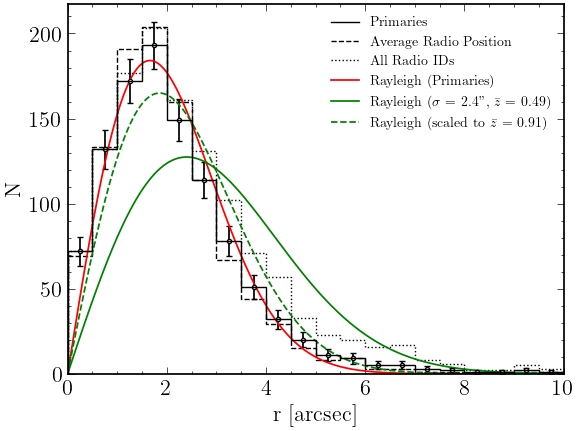

In [29]:
r_range = np.linspace(0,10,1000)
d_range = np.linspace(0,80,1000)

fig, ax = plt.subplots()
ax.stairs(primaries_sc_offset_hist, r_bins, label='Primaries', zorder=10)
ax.errorbar(r_bin_centers, primaries_sc_offset_hist, yerr=primaries_sc_offset_hist_err, fmt='.', c='k')
ax.stairs(all_average_sc_offset_hist, r_bins, color='k', linestyle='--',  label='Average Radio Position')
ax.stairs(all_sc_offset_hist, r_bins, color='k', linestyle=':',  label='All Radio IDs')
ax.plot(r_range, rayleigh(r_range, A_best, sigma_best), c='r', label=r'Rayleigh (Primaries)')
ax.plot(r_range, rayleigh(r_range, A_best, sigma_lr), c='g', label=r'Rayleigh ($\sigma$ = 2.4", $\bar{z}$ = 0.49)')
ax.plot(r_range, rayleigh(r_range, A_best, sigma_lr_radio), linestyle='--', c='g', label=r'Rayleigh (scaled to $\bar{z}$ = 0.91)')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,10)
ax.legend(fontsize=10)
plt.savefig(utils.ROOT+'/figures/source_counterpart_offsets.pdf', dpi=1000)
plt.show()

In [30]:
print('The width of the Rayleigh distribution = {:.2f}'.format(sigma_best))
print('Sigma = {:.2f} (z = {:.2f}) scales to {:.2f} (z = {:.2f})'.format(sigma_lr, z_viking, sigma_lr_radio, primaries_median_z))

The width of the Rayleigh distribution = 1.66
Sigma = 2.40 (z = 0.49) scales to 1.85 (z = 0.91)


### Multiples

#### Fluxes

In [31]:
flux_ordered = [group.counterpart_flux_sorted for group in herschel_vla['multiples']]
first_flux = [list_[0] for list_ in flux_ordered]
second_flux = [list_[1] for list_ in flux_ordered]
third_flux = [list_[2] for list_ in flux_ordered]

In [32]:
flux_contributions = [group.counterpart_flux_contribution() for group in herschel_vla['multiples']]
first_contribution = [list_[0] for list_ in flux_contributions]
second_contribution = [list_[1] for list_ in flux_contributions]
third_contribution = [list_[2] for list_ in flux_contributions]
source_fluxes = [group.source.fluxes[0]*1000 for group in herschel_vla['multiples']]

In [33]:
def create_equal_width_bins(x, n_bins):
    split_array = np.array_split(sorted(x), n_bins)
    equal_bins = [split_array[0][0]]+[split_array[it][-1] for it in range(n_bins)]
    return equal_bins

equal_width_bins = create_equal_width_bins(source_fluxes, 5)

In [34]:
first_contribution_average, bin_edges, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 50))
first_contribution_low, _, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 16))
first_contribution_high, _, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 84))

first_flux_average, _, _ = binned_statistic(source_fluxes, first_flux, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 50))
first_flux_low, _, _ = binned_statistic(source_fluxes, first_flux, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 16))
first_flux_high, _, _ = binned_statistic(source_fluxes, first_flux, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 84))

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

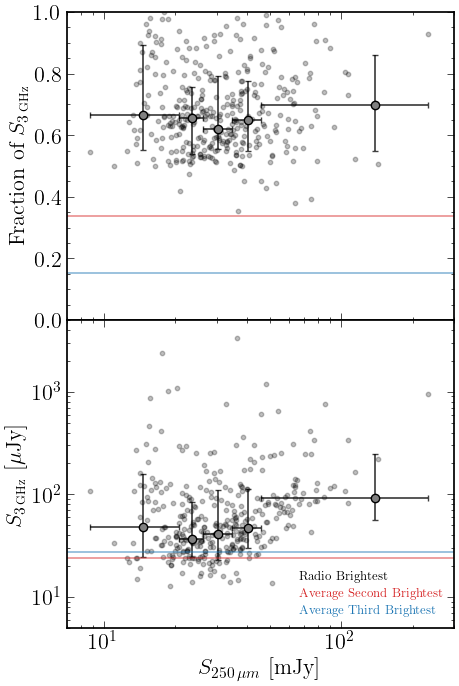

In [35]:
alpha = 0.75

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(5,8))
ax1.scatter(source_fluxes, first_contribution, alpha=0.25, s=10, label=r'Radio Brightest')

markers, caps, bars = ax1.errorbar(bin_centers, first_contribution_average, xerr=(np.diff(bin_edges)/2), yerr=(first_contribution_average-first_contribution_low, first_contribution_high-first_contribution_average), mfc='grey', fmt='o')
[bar.set_alpha(alpha) for bar in bars]
[cap.set_alpha(alpha) for cap in caps]

ax1.axhline(np.nanmedian(second_contribution), c='tab:red', alpha=0.5, label=r'Average Second Brightest')
ax1.axhline(np.nanmedian(third_contribution), c='tab:blue', alpha=0.5, label=r'Average Third Brightest')

ax2.scatter(source_fluxes, first_flux, alpha=0.25, s=10, label=r'Radio Brightest')

markers, caps, bars = ax2.errorbar(bin_centers, first_flux_average, xerr=(np.diff(bin_edges)/2), yerr=(first_flux_average-first_flux_low, first_flux_high-first_flux_average), mfc='grey', fmt='o')
[bar.set_alpha(alpha) for bar in bars]
[cap.set_alpha(alpha) for cap in caps]

ax2.axhline(np.nanmedian(second_flux), c='tab:red', alpha=0.5, label=r'Average Second Brightest')
ax2.axhline(np.nanmedian(third_flux), c='tab:blue', alpha=0.5, label=r'Average Third Brightest')

ax1.set_ylabel(r'Fraction of $S_{\small 3\,\textrm{GHz}}$')
ax2.set_xlabel(r'$S_{\small 250\,\mu m}$ [mJy]')
ax2.set_ylabel(r'$S_{\small 3\,\textrm{GHz}}$ [$\mu$Jy]')
ax2.set_xlim(7e0, 3e2)
ax1.set_ylim(0, 1)
ax2.set_ylim(5e0, 5e3)
ax2.loglog()
ax2.legend(handlelength=0, markerscale=0, fontsize=9, labelcolor=['k', 'tab:red', 'tab:blue'], loc='lower right')
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/multiples_flux_contribution.pdf', dpi=1000)
plt.show()

#### Redshifts

In [36]:
multiples_cc_zdiff = list(chain.from_iterable([obj.counterpart_counterpart_z_difference()[0] for obj in herschel_vla_flux['multiples']]))
multiples_cc_zdiff_err = list(chain.from_iterable([obj.counterpart_counterpart_z_difference()[1] for obj in herschel_vla_flux['multiples']]))
multiples_cc_offsets = list(chain.from_iterable([obj.counterpart_counterpart_separations() for obj in herschel_vla_flux['multiples']]))

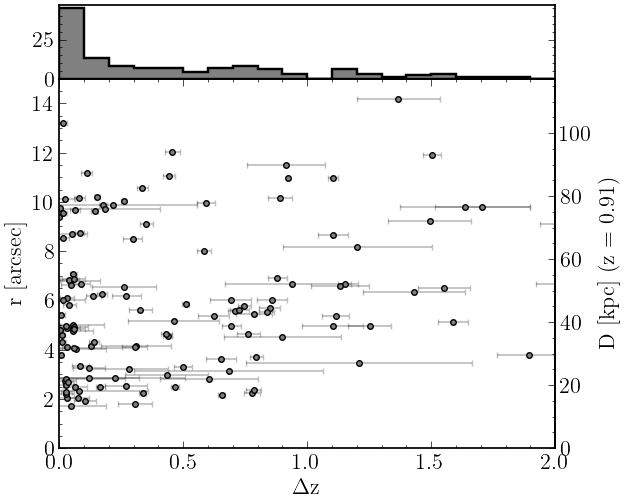

In [37]:
alpha = 0.25

fig, ax = plt.subplots()
markers, caps, bars = ax.errorbar(multiples_cc_zdiff, multiples_cc_offsets, xerr=multiples_cc_zdiff_err, markerfacecolor='gray', fmt='o', markersize=4)
[bar.set_alpha(alpha) for bar in bars]
[cap.set_alpha(alpha) for cap in caps]

ax.tick_params(axis='y', which='both', right=False)
secax = ax.secondary_yaxis('right', functions=(partial(separation_to_distance, z=primaries_median_z), partial(distance_to_separation, z=primaries_median_z)))
secax.set_ylabel(r'D [kpc] (z = {:.2f})'.format(primaries_median_z))

axin = ax.inset_axes([0,1,1,0.2])
axin.hist(multiples_cc_zdiff, bins=20, range=(0,2), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
axin.set_xlim(0,2)
axin.set_xticks([])

ax.set_xlim(0,2)
ax.set_ylim(0,15)
ax.set_xlabel(r'$\Delta$z')
ax.set_ylabel(r'r [arcsec]')
plt.savefig(utils.ROOT+'/figures/multiples_separation.pdf', dpi=1000)
plt.show()

### Missing IDs

In [88]:
print('The number of sources with no IDs (or non-signficant associations) = {} ({:.2f}%)'.format(len(herschel_vla_flux['blanks']), (len(herschel_vla_flux['blanks'])/n_sources_flux)*100))

The number of sources with no IDs (or non-signficant associations) = 271 (20.47%)


In [121]:
def colour(wave_obs_um_1, wave_obs_um_2, z, t, beta):
    wave_obs_m_1 = wave_obs_um_1*1e-6
    wave_obs_m_2 = wave_obs_um_2*1e-6
    wave_rest_m_1 = wave_obs_m_1/(1+z)
    wave_rest_m_2 = wave_obs_m_2/(1+z)
    nu_rest_1 = c.value/wave_rest_m_1
    nu_rest_2 = c.value/wave_rest_m_2

    colour = mbb(nu_rest_1, 1, t, beta)/mbb(nu_rest_2, 1, t, beta)
    return colour

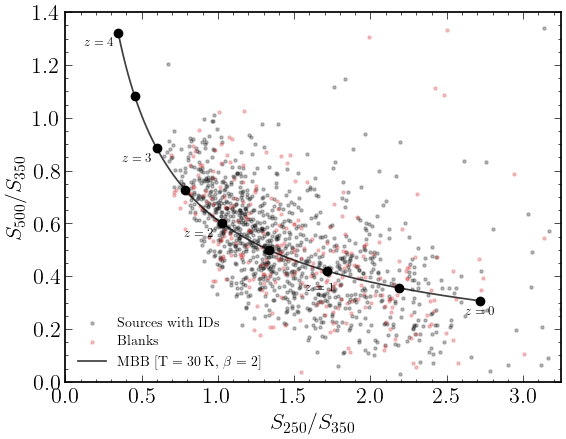

In [267]:
z_range = np.linspace(0,4,100)

blanks_250_350 = [blank.fluxes[0]/blank.fluxes[1] for blank in herschel_vla_flux['blanks']]
blanks_500_350 = [blank.fluxes[2]/blank.fluxes[1] for blank in herschel_vla_flux['blanks']]

primaries_250_350 = [obj.source.fluxes[0]/obj.source.fluxes[1] for obj in herschel_vla_flux['primaries']]
primaries_500_350 = [obj.source.fluxes[2]/obj.source.fluxes[1] for obj in herschel_vla_flux['primaries']]

fig, ax = plt.subplots()
ax.scatter(primaries_250_350, primaries_500_350, alpha=0.25, s=5, label=r'Sources with IDs')
ax.scatter(blanks_250_350, blanks_500_350, alpha=0.25, s=5, label='Blanks')
ax.plot(colour(250, 350, z_range, 30, 2), colour(500, 350, z_range, 30, 2), alpha=0.75, label=r'MBB [T = 30\,K, $\beta$ = 2]')
ax.text(colour(250, 350, 0, 30, 2)-0.1, colour(500, 350, 0, 30, 2)-0.05, r'$z = 0$', fontsize=9)
ax.text(colour(250, 350, 1, 30, 2)-0.15, colour(500, 350, 1, 30, 2)-0.075, r'$z = 1$', fontsize=9)
ax.text(colour(250, 350, 2, 30, 2)-0.25, colour(500, 350, 2, 30, 2)-0.05, r'$z = 2$', fontsize=9)
ax.text(colour(250, 350, 3, 30, 2)-0.225, colour(500, 350, 3, 30, 2)-0.05, r'$z = 3$', fontsize=9)
ax.text(colour(250, 350, 4, 30, 2)-0.225, colour(500, 350, 4, 30, 2)-0.05, r'$z = 4$', fontsize=9)
ax.scatter(colour(250, 350, np.array([0,0.5,1,1.5,2,2.5,3,3.5,4]), 30, 2), colour(500, 350, np.array([0,0.5,1,1.5,2,2.5,3,3.5,4]), 30, 2), c='k')
ax.set_xlabel(r'$S_{250}/S_{350}$')
ax.set_ylabel(r'$S_{500}/S_{350}$')
ax.set_xlim(0,3.25)
ax.set_ylim(0,1.4)
ax.legend(fontsize=10, loc='lower left', markerscale=1)
plt.savefig(utils.ROOT+'/figures/blank_fir_colours.pdf', dpi=1000)
plt.show()

In [220]:
_, herschel_vla_p01 = cosmos.get_groups(r_max_arcsec=r_max, p_max=0.1, n=100000)

Calculating P Values: 100%|██████████| 7230/7230 [00:49<00:00, 144.95it/s]


In [228]:
herschel_vla_flux_p01 = apply_flux_limit(herschel_vla_p01, flux_limit)

In [237]:
print('Number of blank sources if we allow P < 0.1 = {} (Down by {})'.format(len(herschel_vla_flux_p01['blanks']), len(herschel_vla_flux['blanks']) - len(herschel_vla_flux_p01['blanks'])))

Number of blank sources if we allow P < 0.1 = 254 (Down by 17)


### Galaxy Main Sequence

In [38]:
def scoville_ms(logm_star, z):
    a = (0.59*logm_star)-5.77
    b = (0.22*logm_star)+0.59
    return (10**a)*((1+z)**b)

def scoville_ssfr(logm_star, z):
    ssfr_yr = (scoville_ms(logm_star, z)/(10**logm_star))/u.yr
    return ssfr_yr.to(1/u.Gyr)

def sfr_from_ssfr(logm_star, formation_time_gyr=1, fraction_of_hubble=None):
    m_star = (10**logm_star)*u.M_sun
    if fraction_of_hubble is not None:
        formation_time = fraction_of_hubble*cosmo.hubble_time
    else:
        formation_time = formation_time_gyr*u.Gyr
    ssfr = 1/formation_time
    sfr = m_star*ssfr
    return (sfr).to(u.M_sun/u.yr).value

def ssfr_from_sfr(logm_star, sfr):
    m_star = (10**logm_star)*u.M_sun
    sfr = sfr*(u.Msun/u.yr)
    ssfr = sfr/m_star
    return ssfr.to(1/u.Gyr)

In [72]:
def speagle_log_tc(z):
    return 1.143-(1.026*np.log10(1+z))-(0.599*(np.log10(1+z)**2))+(0.528*(np.log10(1+z)**3))

def speagle_ssfr_ms(log_mass, z):
    a = -0.16-(0.026*(10**speagle_log_tc(z)))
    b = log_mass+0.025
    c = 6.51-(0.11*(10**speagle_log_tc(z)))
    return 10**((a*b)-c+9)

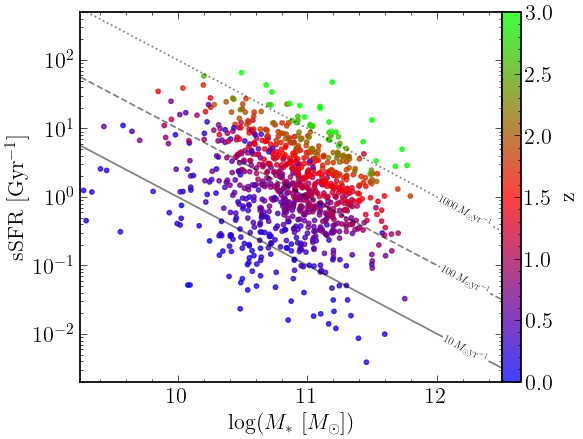

In [282]:
logm_range = np.linspace(9,13,1000)
alpha = 0.5

fig, ax = plt.subplots()

sfrs = np.array([pair.sfr().value for pair in herschel_vla_flux['primaries']])
masses = np.array([pair.counterpart.stellar_mass for pair in herschel_vla_flux['primaries']])
redshifts = np.array([pair.counterpart.redshift for pair in herschel_vla_flux['primaries']])
ssfrs = ssfr_from_sfr(masses, sfrs)

ax.plot(logm_range, ssfr_from_sfr(logm_range, 10), 'k-', alpha=alpha, label=r'$10\,M_{\odot}$yr$^{-1}$')
ax.plot(logm_range, ssfr_from_sfr(logm_range, 100), 'k--', alpha=alpha, label=r'$100\,M_{\odot}$yr$^{-1}$')
ax.plot(logm_range, ssfr_from_sfr(logm_range, 1000), 'k:', alpha=alpha, label=r'$1000\,M_{\odot}$yr$^{-1}$')

#ax.plot(logm_range, speagle_ssfr_ms(logm_range, 0), c='k')
#ax.plot(logm_range, scoville_ssfr(logm_range, 0), c='tab:red')
#ax.plot(logm_range, speagle_ssfr_ms(logm_range, 1), c='k')
#ax.plot(logm_range, scoville_ssfr(logm_range, 1), c='tab:red')
#ax.plot(logm_range, speagle_ssfr_ms(logm_range, 2), c='k')
#ax.plot(logm_range, scoville_ssfr(logm_range, 2), c='tab:red')
#ax.plot(logm_range, speagle_ssfr_ms(logm_range, 3), c='k')
#ax.plot(logm_range, scoville_ssfr(logm_range, 3), c='tab:red')

sc = ax.scatter(masses, ssfrs, c=redshifts, s=10, alpha=0.75, vmin=0, vmax=3, cmap='brg')
ax.set_xlim(9.25,12.5)
ax.set_ylim(2e-3, 5e2)
ax.set_xlabel(r'log($M_{*}$ [$M_{\odot}$])')
ax.set_ylabel(r'sSFR [Gyr$^{-1}$]')
ax.semilogy()
plt.colorbar(sc, pad=0, label=r'z')
labelLines(ax.get_lines(), fontsize=8, xvals=[12.25,12.25,12.25])
plt.savefig(utils.ROOT+'/figures/ssfr.pdf', dpi=1000)
plt.show()

The SFR clearly shows our far-IR bias to high SFR, but in sSFR we see that this corresponds to a diagonal limit, which means that we are still observing this downward trend.

### Differentiating SMGs from Field Galaxies

In [45]:
smg_redshifts = np.array([pair.counterpart.redshift for pair in herschel_vla_flux['primaries']])
smg_gr = np.array([pair.counterpart.g_mag for pair in herschel_vla_flux['primaries']]) - np.array([pair.counterpart.r_mag for pair in herschel_vla_flux['primaries']])
smg_hk = np.array([pair.counterpart.h_mag for pair in herschel_vla_flux['primaries']]) - np.array([pair.counterpart.k_mag for pair in herschel_vla_flux['primaries']])
smg_mass = np.array([pair.counterpart.stellar_mass for pair in herschel_vla_flux['primaries']])
smg_radius = np.array([pair.r for pair in herschel_vla_flux['primaries']])
smg_radioflux = np.array([pair.counterpart.fluxes.item() for pair in herschel_vla_flux['primaries']])

In [51]:
cosmos_redshifts = cosmos2020['lp_zPDF']
cosmos_gr = cosmos2020['lp_MG'] - cosmos2020['lp_MR']
cosmos_hk = cosmos2020['lp_MH'] - cosmos2020['lp_MK']
cosmos_mass = cosmos2020['lp_mass_med']

In [52]:
cosmos_redshifts_random = np.random.choice(cosmos_redshifts, len(smg_redshifts), replace=False)
cosmos_gr_random = np.random.choice(cosmos_gr, len(smg_gr), replace=False)
cosmos_hk_random = np.random.choice(cosmos_hk, len(smg_hk), replace=False)
cosmos_mass_random = np.random.choice(cosmos_mass, len(smg_mass), replace=False)
cosmos_radioflux_random = np.random.choice(vla['total_int_flux'], len(smg_radioflux), replace=False)

In [53]:
r_max_arcsec = 10
rand_r = []

while len(rand_r) < len(smg_radius):
    r_max_deg = r_max_arcsec/3600
    ra_random, dec_random = np.random.uniform(-r_max_deg, r_max_deg), np.random.uniform(-r_max_deg, r_max_deg)
    r = np.sqrt(((0 - ra_random)**2)+((0 - dec_random)**2))*3600
    if r <= r_max_arcsec:
        rand_r.append(r)

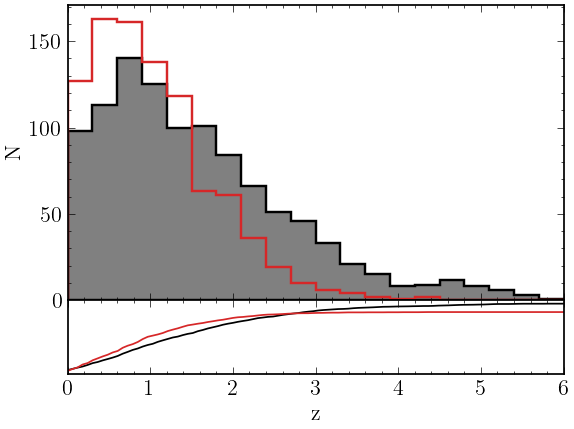

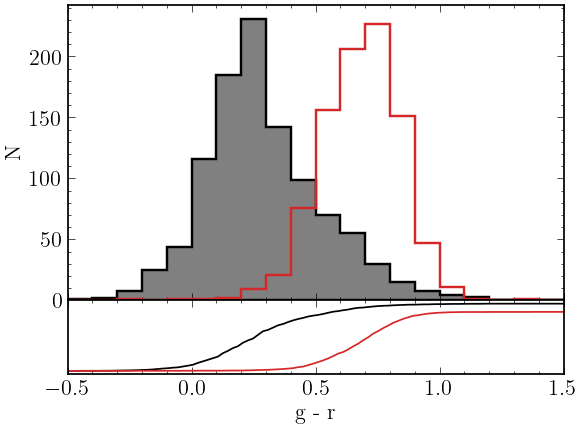

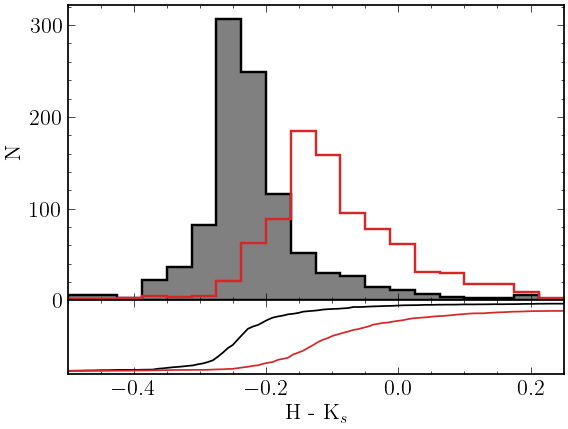

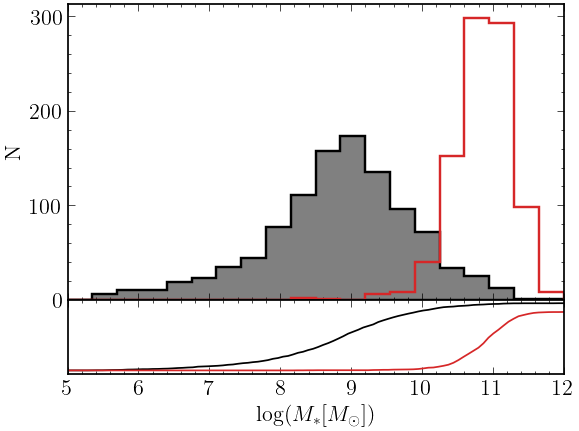

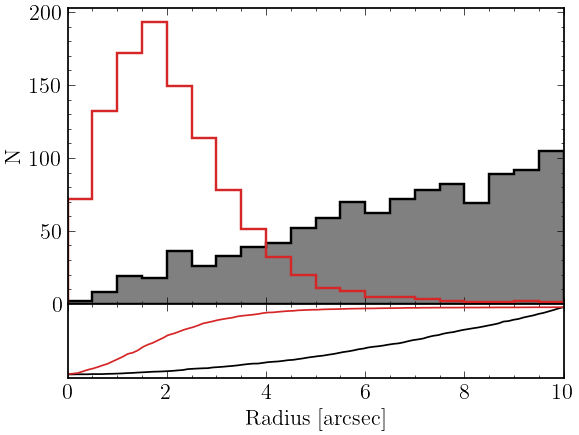

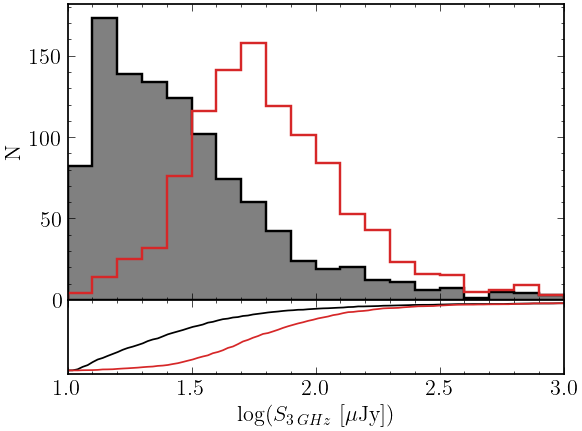

In [54]:
z_range = np.linspace(0,6,100)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[4,1])
ax1.hist(cosmos_redshifts_random, bins=20, range=(0,6), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
ax1.hist(smg_redshifts, bins=20, range=(0,6), histtype='step', linewidth=1.75)
ax2.plot(z_range, np.array(cumfreq(cosmos_redshifts_random, 100, defaultreallimits=(0,6)).cumcount))
ax2.plot(z_range, np.array(cumfreq(smg_redshifts, 100, defaultreallimits=(0,6)).cumcount))
ax2.set_yticks([])
ax1.set_ylabel(r'N')
ax2.set_xlabel(r'z')
ax2.set_xlim(0,6)
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/ml_redshift.pdf', dpi=1000)
plt.show()

gr_range = np.linspace(-0.5,1.5,100)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[4,1])
ax1.hist(cosmos_gr_random, bins=20, range=(-0.5,1.5), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
ax1.hist(smg_gr, bins=20, range=(-0.5,1.5), histtype='step', linewidth=1.75)
ax2.plot(gr_range, np.array(cumfreq(cosmos_gr_random, 100, defaultreallimits=(-0.5,1.5)).cumcount))
ax2.plot(gr_range, np.array(cumfreq(smg_gr, 100, defaultreallimits=(-0.5,1.5)).cumcount))
ax2.set_yticks([])
ax1.set_ylabel(r'N')
ax2.set_xlabel(r'g - r')
ax2.set_xlim(-0.5,1.5)
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/ml_gr.pdf', dpi=1000)
plt.show()

hk_range = np.linspace(-0.5,0.25,100)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[4,1])
ax1.hist(cosmos_hk_random, bins=20, range=(-0.5,0.25), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
ax1.hist(smg_hk, bins=20, range=(-0.5,0.25), histtype='step', linewidth=1.75)
ax2.plot(hk_range, np.array(cumfreq(cosmos_hk_random, 100, defaultreallimits=(-0.5,0.25)).cumcount))
ax2.plot(hk_range, np.array(cumfreq(smg_hk, 100, defaultreallimits=(-0.5,0.25)).cumcount))
ax2.set_yticks([])
ax1.set_ylabel(r'N')
ax2.set_xlabel(r'H - K$_s$')
ax2.set_xlim(-0.5,0.25)
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/ml_hk.pdf', dpi=1000)
plt.show()

mass_range = np.linspace(5,12,100)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[4,1])
ax1.hist(cosmos_mass_random, bins=20, range=(5,12), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
ax1.hist(smg_mass, bins=20, range=(5,12), histtype='step', linewidth=1.75)
ax2.plot(mass_range, np.array(cumfreq(cosmos_mass_random, 100, defaultreallimits=(5,12)).cumcount))
ax2.plot(mass_range, np.array(cumfreq(smg_mass, 100, defaultreallimits=(5,12)).cumcount))
ax2.set_yticks([])
ax1.set_ylabel(r'N')
ax2.set_xlabel(r'log($M_* [M_{\odot}]$)')
ax2.set_xlim(5,12)
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/ml_mass.pdf', dpi=1000)
plt.show()

r_range = np.linspace(0,10,100)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[4,1])
ax1.hist(rand_r, bins=20, range=(0,10), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
ax1.hist(smg_radius, bins=20, range=(0,10), histtype='step', linewidth=1.75)
ax2.plot(r_range, np.array(cumfreq(rand_r, 100, defaultreallimits=(0,10)).cumcount))
ax2.plot(r_range, np.array(cumfreq(smg_radius, 100, defaultreallimits=(0,10)).cumcount))
ax2.set_yticks([])
ax1.set_ylabel(r'N')
ax2.set_xlabel(r'Radius [arcsec]')
ax2.set_xlim(0,10)
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/ml_radius.pdf', dpi=1000)
plt.show()

flux_range = np.linspace(1,3,100)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, height_ratios=[4,1])
ax1.hist(np.log10(cosmos_radioflux_random), bins=20, range=(1,3), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
ax1.hist(np.log10(smg_radioflux), bins=20, range=(1,3), histtype='step', linewidth=1.75)
ax2.plot(flux_range, np.array(cumfreq(np.log10(cosmos_radioflux_random), 100, defaultreallimits=(1,3)).cumcount))
ax2.plot(flux_range, np.array(cumfreq(np.log10(smg_radioflux), 100, defaultreallimits=(1,3)).cumcount))
ax2.set_yticks([])
ax1.set_ylabel(r'N')
ax2.set_xlabel(r'log($S_{3\,GHz}$ [$\mu$Jy])')
ax2.set_xlim(1,3)
plt.subplots_adjust(hspace=0)
plt.savefig(utils.ROOT+'/figures/ml_radioflux.pdf', dpi=1000)
plt.show()

### Cutouts

In [55]:
def create_cutouts(object, bands, r_max_arcsec=0, save=True):

    if isinstance(object, Source):
        source = object
        counterparts = []
    if isinstance(object, Pair):
        source = object.source
        counterparts = [object.counterpart]
    if isinstance(object, Group):
        source = object.source
        counterparts = object.counterparts

    ra_source = source.ra
    dec_source = source.dec

    fig = plt.figure(figsize=(10, 4))
    for idx,band in enumerate(bands):
        print(band)
        file = glob.glob(utils.ROOT+'/images/**/*'+str(ra_source)+'_'+str(dec_source)+'_sdss_'+str(band)+'*.fits')[0]
        print(file)
        if file:
            #file = file_names[idx]
            hdul = fits.open(file)
            wcs = WCS(hdul[0].header)
            image_data = hdul[0].data

            ax = fig.add_subplot(1,len(bands),idx+1,projection=wcs)
            ra, dec = ax.coords[0], ax.coords[1]
            ra.set_format_unit('deg')
            dec.set_format_unit('deg')

            r_max_deg = r_max_arcsec/3600
            source_ra_idx, source_dec_idx = wcs.wcs_world2pix(ra_source, dec_source, 1)
            source_ra_idx_circle, _ = wcs.wcs_world2pix(ra_source+r_max_deg, dec_source, 1)
            for counterpart in counterparts:
                counterpart_ra_idx, counterpart_dec_idx = wcs.wcs_world2pix(counterpart.ra, counterpart.dec, 1)
                ax.scatter(counterpart_ra_idx, counterpart_dec_idx, marker='+', s=50, c='tab:red', alpha=0.75)

            cir = plt.Circle((source_ra_idx, source_dec_idx), source_ra_idx_circle-source_ra_idx, color='k', alpha=0.25, linestyle='--', fill=False)
            ax.add_patch(cir)

            ax.imshow(image_data, cmap='Greys')
            ax.axhline(source_dec_idx, c='tab:red', alpha=0.25)
            ax.axvline(source_ra_idx, c='tab:red', alpha=0.25)
            ax.set_xlabel(r'RA [deg]')
            ax.set_ylabel(r'Dec [deg]')
            ax.axis('off')
            ax.text(0.05, 0.8, band, transform=ax.transAxes)
        else:
            continue
    plt.subplots_adjust(wspace=0, hspace=0)
    if save:
        plt.savefig(utils.ROOT+'/figures/source_'+str(source.id)+'.pdf', dpi=1000)
    plt.show()

#### Blanks

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0023_150.92858795436766_1.5699928104275327_sdss_r_matched-psf_012_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0023_150.92858795436766_1.5699928104275327_sdss_z_matched-psf_012_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0023_150.92858795436766_1.5699928104275327_sdss_g_matched-psf_012_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0023_150.92858795436766_1.5699928104275327_sdss_i_matched-psf_012_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0023_150.92858795436766_1.5699928104275327_sdss_u_matched-psf_012_sci_20.fits


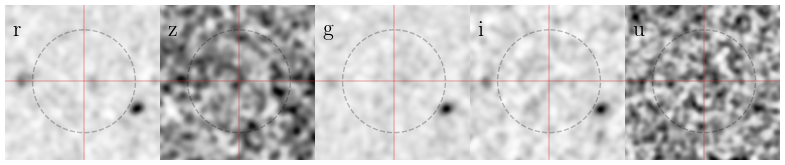

In [56]:
create_cutouts(herschel_vla_flux['blanks'][4], ['r','z','g','i','u'], 10, save=True)

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0072_150.87492862113703_1.4886427494396282_sdss_r_matched-psf_013_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0072_150.87492862113703_1.4886427494396282_sdss_z_matched-psf_013_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0072_150.87492862113703_1.4886427494396282_sdss_g_matched-psf_013_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0072_150.87492862113703_1.4886427494396282_sdss_i_matched-psf_013_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0072_150.87492862113703_1.4886427494396282_sdss_u_matched-psf_013_sci_20.fits


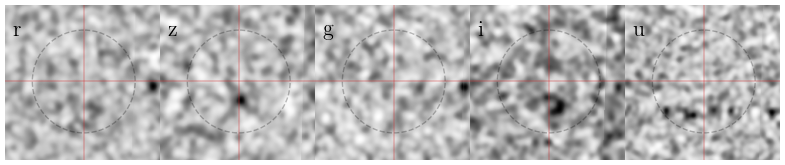

In [57]:
create_cutouts(herschel_vla_flux['blanks'][10], ['r','z','g','i','u'], 10, save=True)

#### Singles

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0001_150.7458307907756_2.343037381541152_sdss_r_matched-psf_073_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0001_150.7458307907756_2.343037381541152_sdss_z_matched-psf_073_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0001_150.7458307907756_2.343037381541152_sdss_g_matched-psf_073_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0001_150.7458307907756_2.343037381541152_sdss_i_matched-psf_073_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0001_150.7458307907756_2.343037381541152_sdss_u_matched-psf_073_sci_20.fits


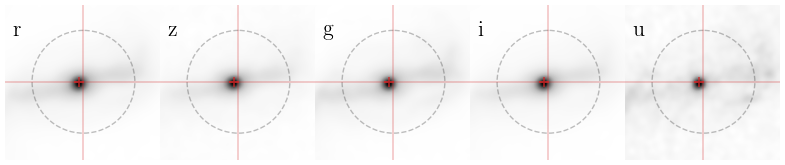

In [58]:
create_cutouts(herschel_vla_flux['singles'][0], ['r','z','g','i','u'], 10, save=True)

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0004_149.92396883228753_3.032548788922274_sdss_r_matched-psf_126_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0004_149.92396883228753_3.032548788922274_sdss_z_matched-psf_126_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0004_149.92396883228753_3.032548788922274_sdss_g_matched-psf_126_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0004_149.92396883228753_3.032548788922274_sdss_i_matched-psf_126_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0004_149.92396883228753_3.032548788922274_sdss_u_matched-psf_126_sci_20.fits


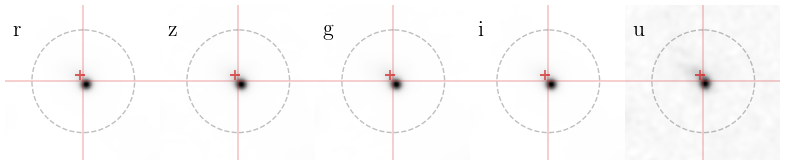

In [59]:
create_cutouts(herschel_vla_flux['singles'][2], ['r','z','g','i','u'], 10, save=True)

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0005_150.50133545224753_2.862531013535786_sdss_r_matched-psf_111_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0005_150.50133545224753_2.862531013535786_sdss_z_matched-psf_111_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0005_150.50133545224753_2.862531013535786_sdss_g_matched-psf_111_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0005_150.50133545224753_2.862531013535786_sdss_i_matched-psf_111_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0005_150.50133545224753_2.862531013535786_sdss_u_matched-psf_111_sci_20.fits


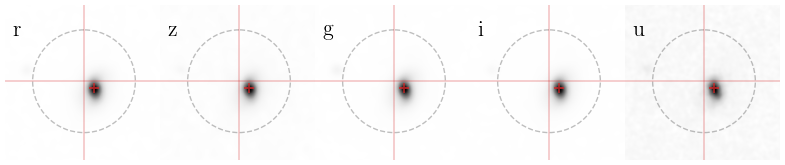

In [60]:
create_cutouts(herschel_vla_flux['singles'][3], ['r','z','g','i','u'], 10, save=True)

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0006_150.33100427582497_1.920944570579132_sdss_r_matched-psf_040_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0006_150.33100427582497_1.920944570579132_sdss_z_matched-psf_040_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0006_150.33100427582497_1.920944570579132_sdss_g_matched-psf_040_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0006_150.33100427582497_1.920944570579132_sdss_i_matched-psf_040_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0006_150.33100427582497_1.920944570579132_sdss_u_matched-psf_040_sci_20.fits


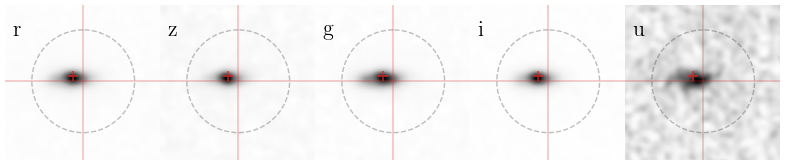

In [61]:
create_cutouts(herschel_vla_flux['singles'][4], ['r','z','g','i','u'], 10, save=True)

#### Multiples

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0042_150.26019023425553_2.5284443394827627_sdss_r_matched-psf_088_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0042_150.26019023425553_2.5284443394827627_sdss_z_matched-psf_088_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0042_150.26019023425553_2.5284443394827627_sdss_g_matched-psf_088_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0042_150.26019023425553_2.5284443394827627_sdss_i_matched-psf_088_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0042_150.26019023425553_2.5284443394827627_sdss_u_matched-psf_088_sci_20.fits


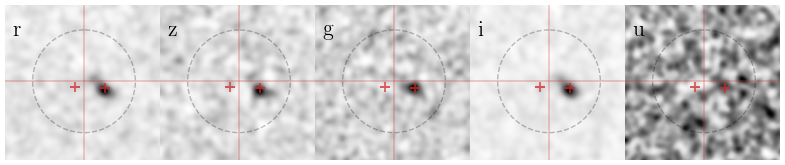

In [62]:
create_cutouts(herschel_vla_flux['multiples'][8], ['r','z','g','i','u'], 10, save=True)

r
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0064_150.60839932295087_2.8588799632719777_sdss_r_matched-psf_110_sci_20.fits
z
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0064_150.60839932295087_2.8588799632719777_sdss_z_matched-psf_110_sci_20.fits
g
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0064_150.60839932295087_2.8588799632719777_sdss_g_matched-psf_110_sci_20.fits
i
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0064_150.60839932295087_2.8588799632719777_sdss_i_matched-psf_110_sci_20.fits
u
/Users/bradleyward/Desktop/Radio-IDs/images/sdss_sci_0_100/0064_150.60839932295087_2.8588799632719777_sdss_u_matched-psf_110_sci_20.fits


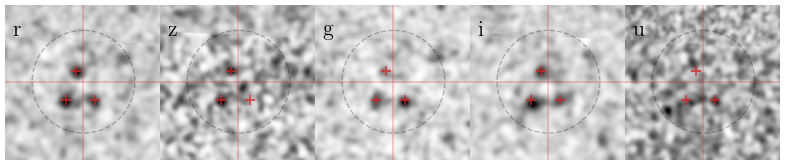

In [63]:
create_cutouts(herschel_vla_flux['multiples'][9], ['r','z','g','i','u'], 10, save=True)